In [67]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


                                              0.0/614.7 kB ? eta -:--:--
     -----                                   81.9/614.7 kB 2.3 MB/s eta 0:00:01
     --------                               143.4/614.7 kB 1.7 MB/s eta 0:00:01
     ----------                             174.1/614.7 kB 1.5 MB/s eta 0:00:01
     --------------                         235.5/614.7 kB 1.4 MB/s eta 0:00:01
     ---------------                        256.0/614.7 kB 1.3 MB/s eta 0:00:01
     -------------------                    317.4/614.7 kB 1.2 MB/s eta 0:00:01
     -------------------------              409.6/614.7 kB 1.4 MB/s eta 0:00:01
     --------------------------------       532.5/614.7 kB 1.6 MB/s eta 0:00:01
     -------------------------------------  614.4/614.7 kB 1.6 MB/s eta 0:00:01
     -------------------------------------- 614.7/614.7 kB 1.5 MB/s eta 0:00:00
                                              0.0/2.8 MB ? eta -:--:--
     -                                        0.1/2.8 MB

In [2]:
pd.options.display.max_columns=100

In [4]:
df_store = pd.read_csv('stores.csv')

In [5]:
df_features = pd.read_csv('features.csv')

In [6]:
df_train = pd.read_csv('train29.csv')

In [7]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [9]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [11]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [12]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [13]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [14]:
print(df.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64


In [16]:
df.shape

(421570, 16)

In [22]:
df.shape #removed markdown 1,2,3,4,5

(421570, 11)

In [23]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315


In [24]:
df['Store'].nunique()

45

In [25]:
df['Dept'].nunique()

81

Look at the average weekly sales for each store and each department to see if there is any weird values or not. There are 45 stores and 81 departments for stores.

In [26]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

C:\Users\ansh\AppData\Local\Temp\ipykernel_12360\2014498793.py:1: FutureWarning: The provided callable <function mean at 0x0000025539982B60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',


Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week.

In [27]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,191.461281,8.684,B,118221


In [28]:
#1358 rows in 421570 rows means 0.3%, so delete and ignore these rows which contains wrong sales values.
df = df.loc[df['Weekly_Sales'] > 0]
df.shape

(420212, 11)

<IPython.core.display.Javascript object>

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

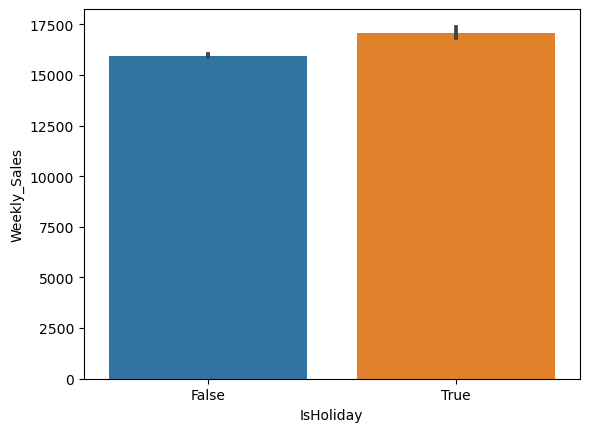

In [29]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [30]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [31]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

In [32]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

In [33]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,126.669267,9.003,B,126512
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,140.421786,8.745,B,103681
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,129.836400,7.874,B,126512
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,136.689571,8.763,B,103681
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,182.783277,8.724,A,200898


In [34]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

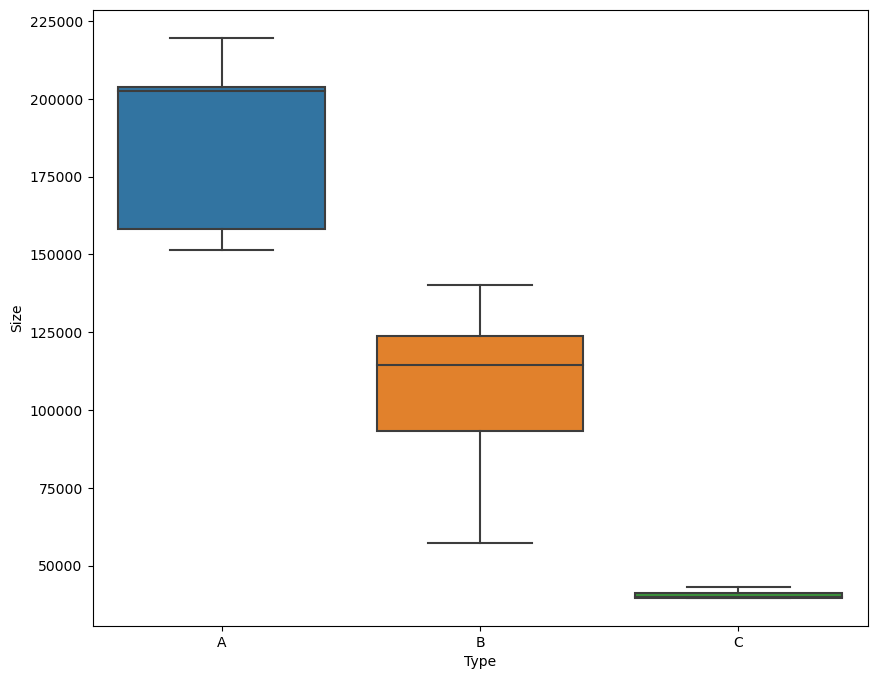

In [35]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

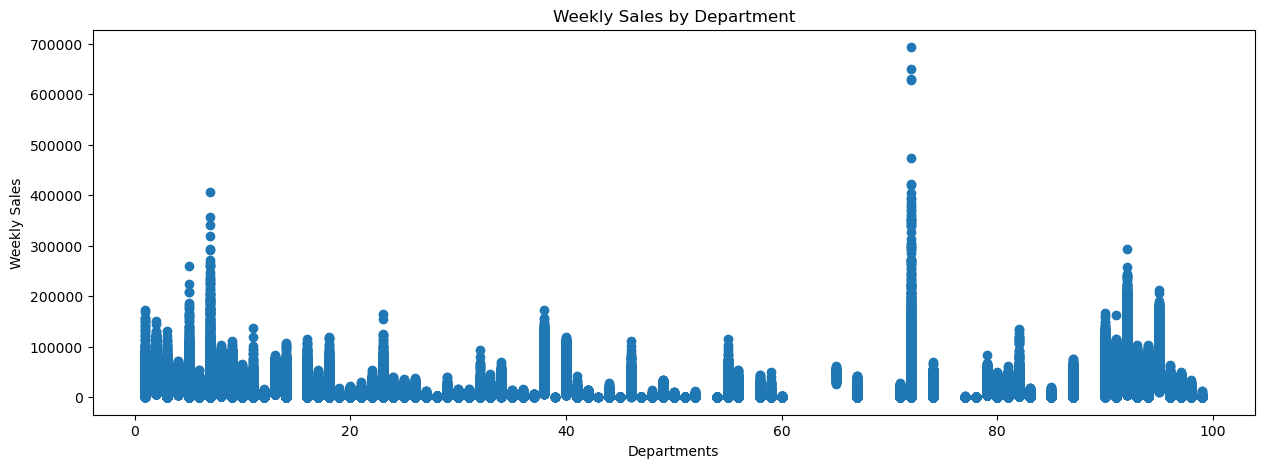

In [36]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

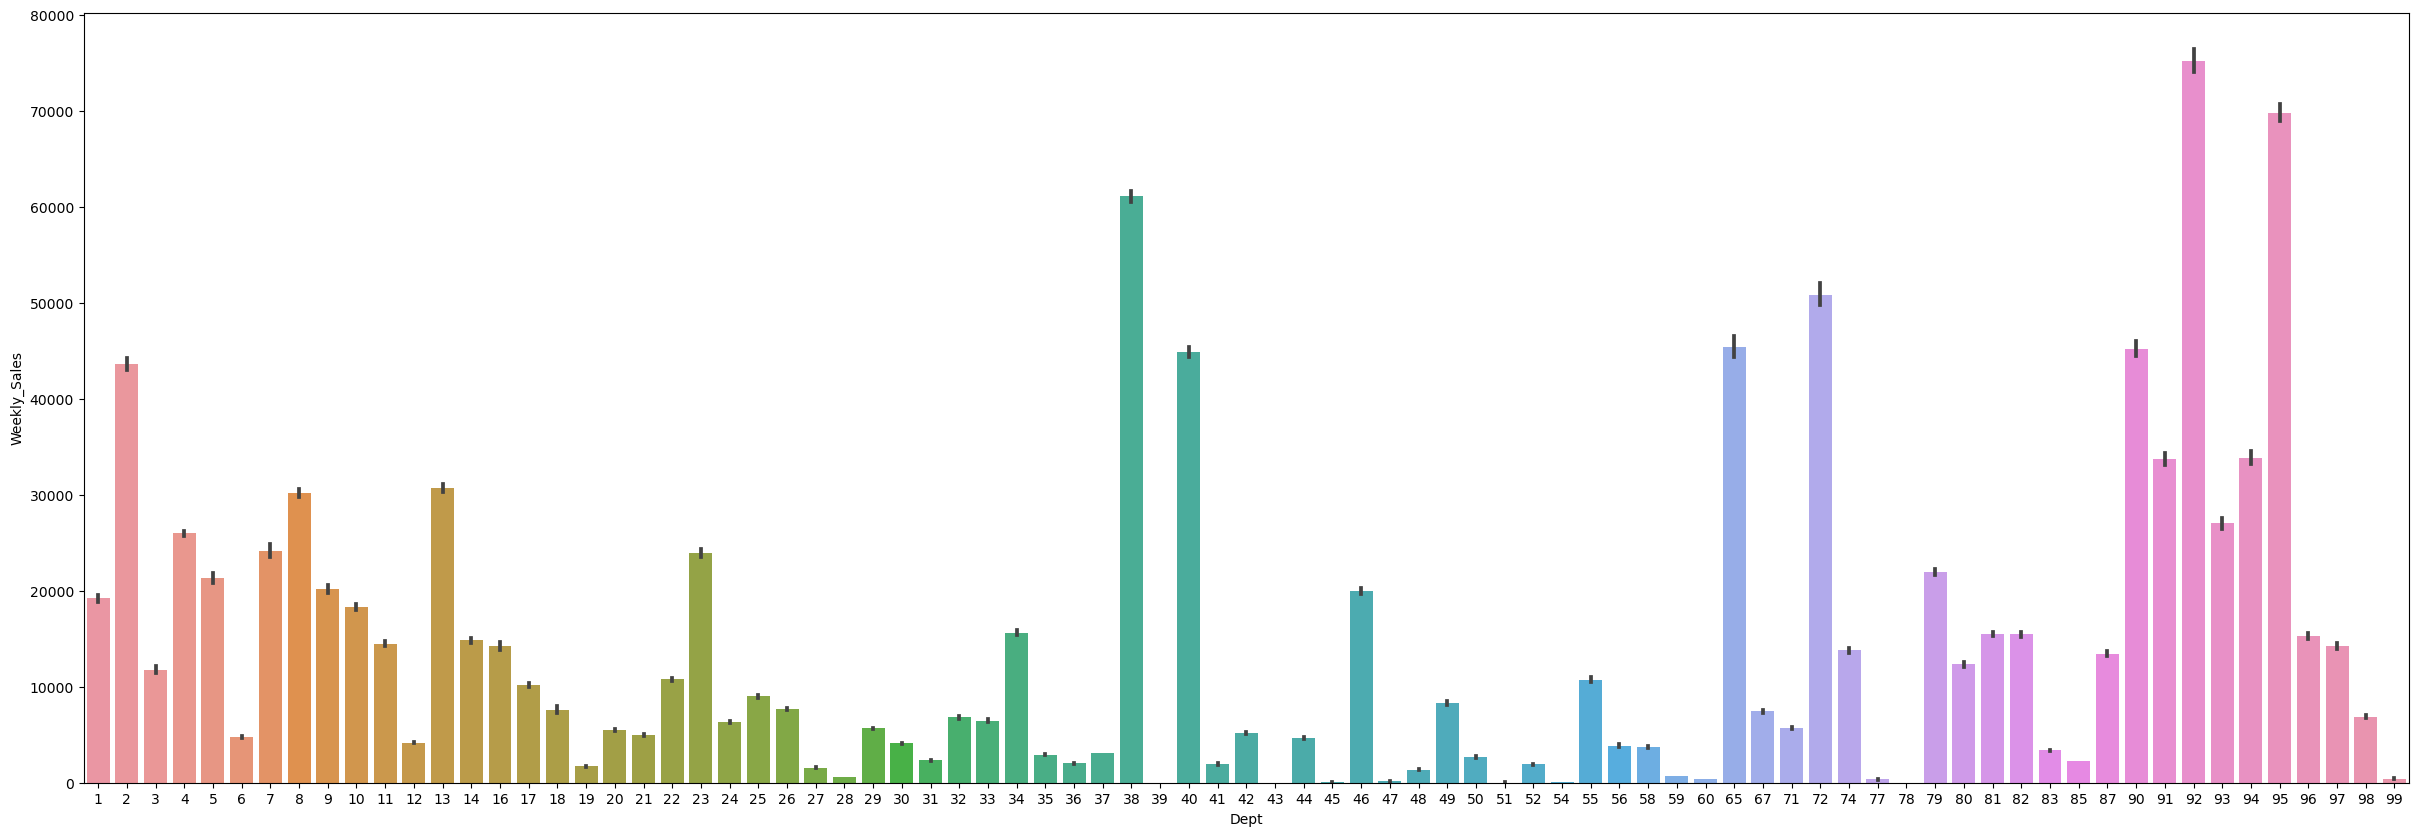

In [38]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

It is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

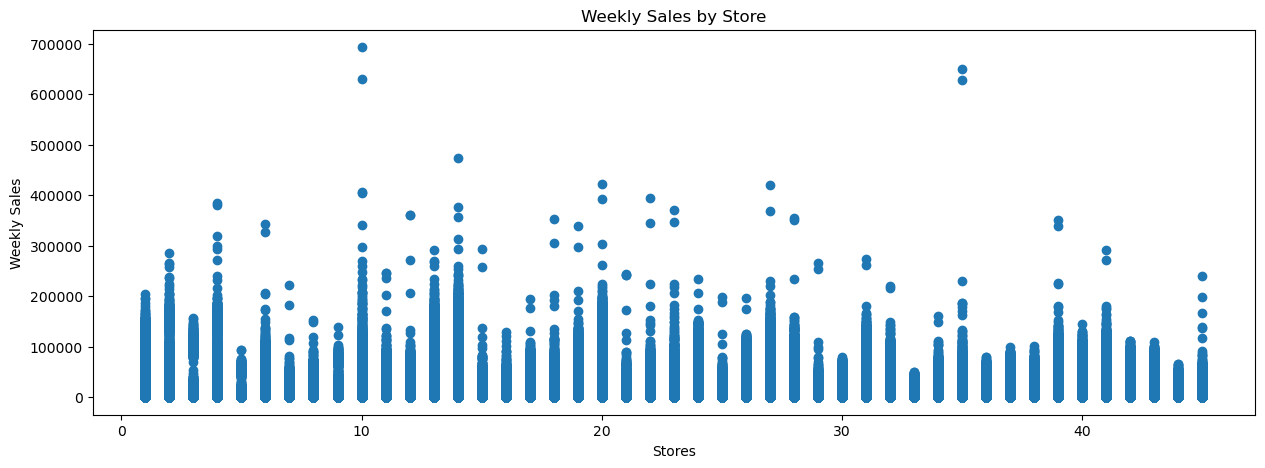

In [39]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

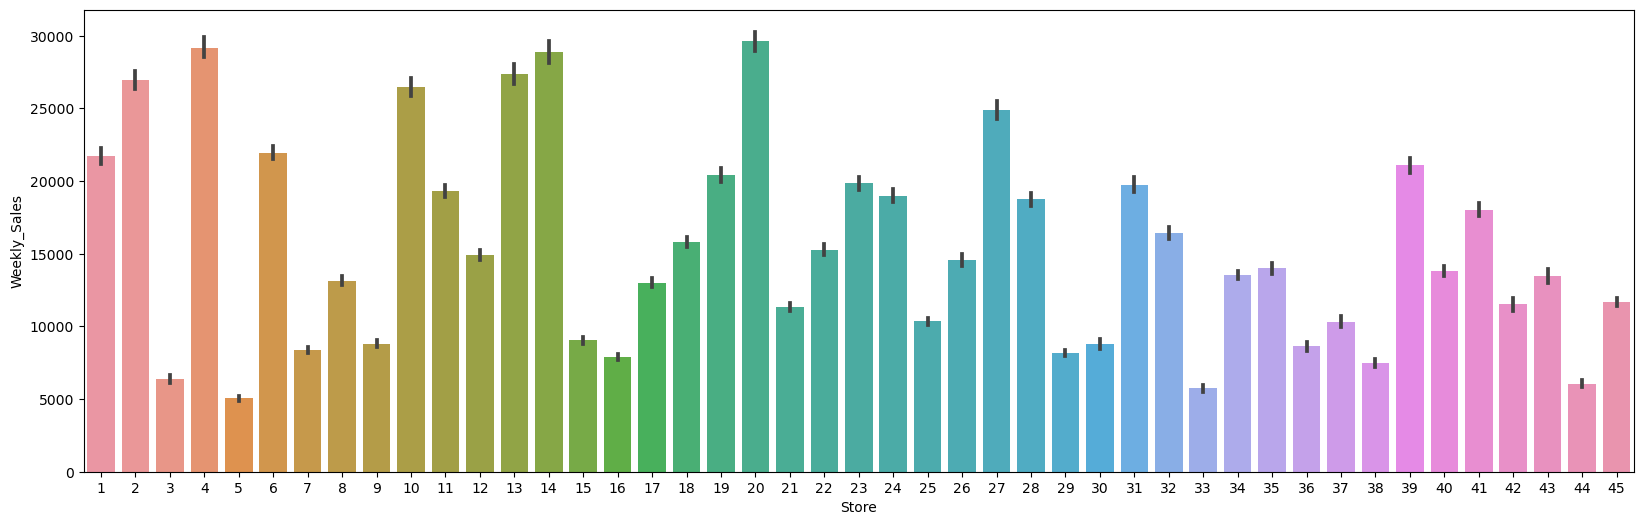

In [40]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

# Changing Date to Datetime and Creating New Columns

In [42]:
df["Date"] = pd.to_datetime(df["Date"])  # convert to datetime
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df['Date'].dt.month 
df['year'] = df['Date'].dt.year


In [43]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [44]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

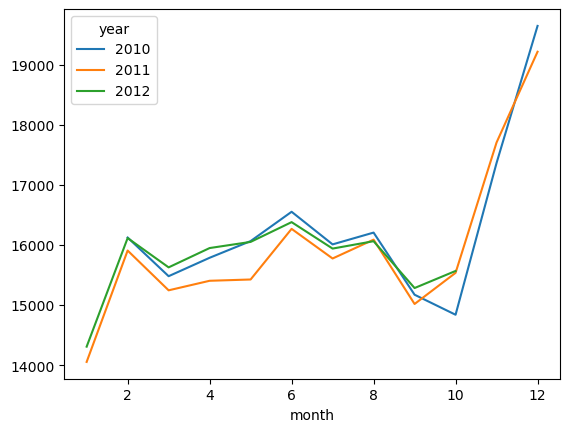

In [45]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

<Axes: xlabel='week'>

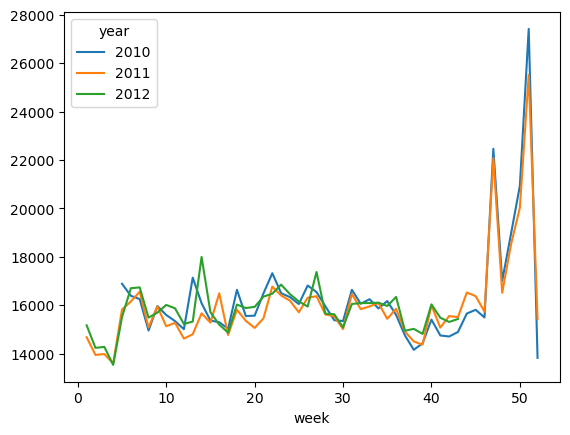

In [46]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

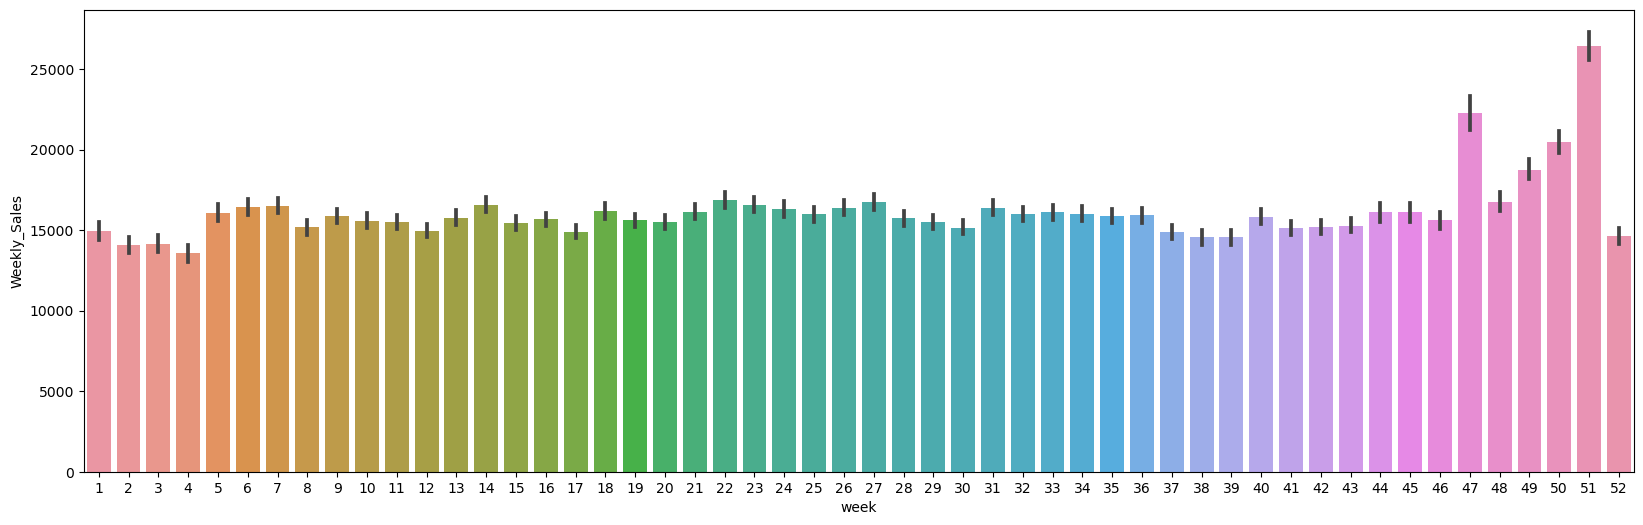

In [47]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

# Effects of unemployment,cpi,fuel price and  temperature 

<Axes: xlabel='Fuel_Price'>

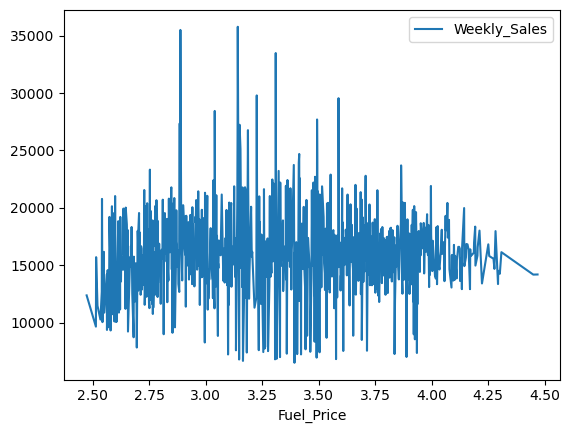

In [48]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

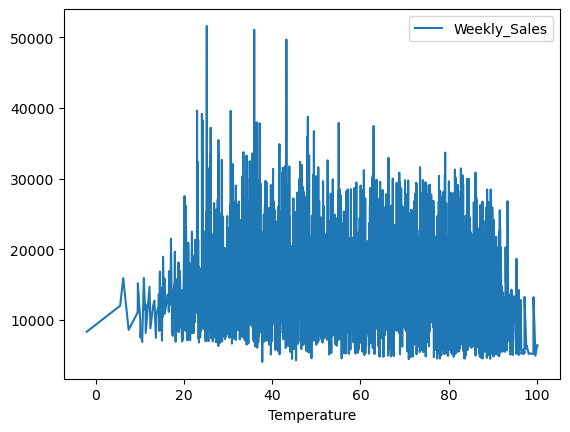

In [49]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

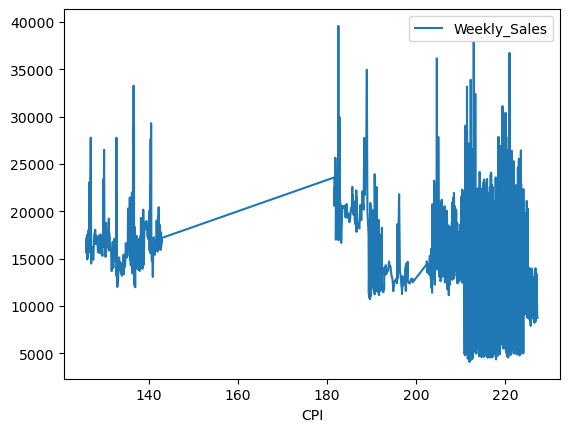

In [50]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

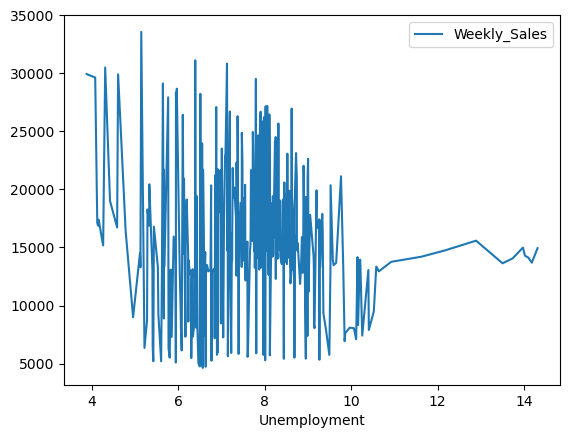

In [51]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

In [52]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

# Findings and Explorations
Cleaning Process:
The data has no too much missing values. All columns was checked.
I choose rows which has higher than 0 weekly sales. Minus values are 0.3% of data. So, I dropped them.
Null values in markdowns changed to zero. Because, they were written as null if there were no markdown on this department.
Explorations & Findings:
There are 45 stores and 81 department in data. Departments are not same in all stores.
Although department 72 has higher weekly sales values, on average department 92 is the best. It shows us, some departments has higher values as seasonal like Thanksgiving. It is consistant when we look at the top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday time.
Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 are on the first and second rank. It means that some areas has higher seasonal sales.
Stores has 3 types as A, B and C according to their sizes. Almost half of the stores are bigger than 150000 and categorized as A. According to type, sales of the stores are changing.
As expected, holiday average sales are higher than normal dates.
Christmas holiday introduces as the last days of the year. But people generally shop at 51th week. So, when we look at the total sales of holidays, Thankgiving has higher sales between them which was assigned by Walmart.
Year 2010 has higher sales than 2011 and 2012. But, November and December sales are not in the data for 2012. Even without highest sale months, 2012 is not significantly less than 2010, so after adding last two months, it can be first.
It is obviously seen that week 51 and 47 have higher values and 50-48 weeks follow them. Interestingly, 5th top sales belongs to 22th week of the year. This results show that Christmas, Thankgiving and Black Friday are very important than other weeks for sales and 5th important time is 22th week of the year and it is end of the May, when schools are closed. Most probably, people are preparing for holiday at the end of the May.
January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.
CPI, temperature, unemployment rate and fuel price have no pattern on weekly sales.

In [57]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [58]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [59]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

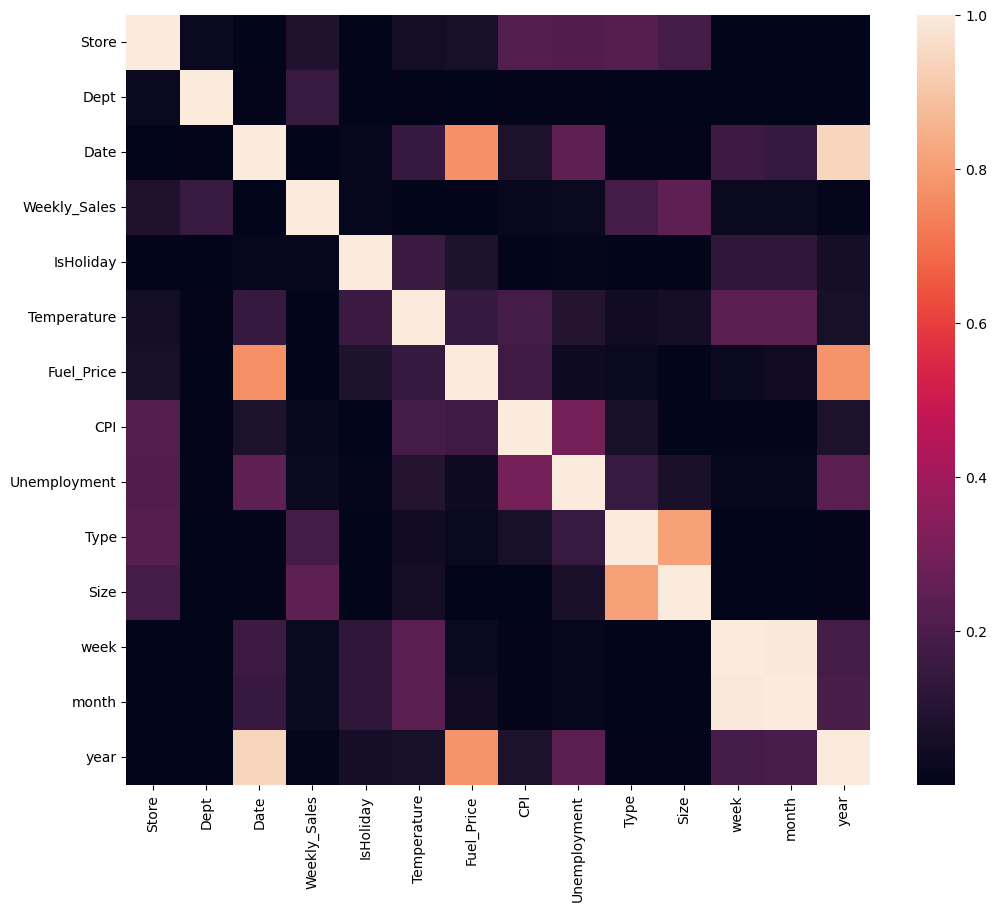

In [60]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

In [61]:
drop_col = ['Temperature','CPI','Unemployment'] #because they have no effect on sales
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

In [62]:
#size and type are highly correlated with weekly sales

In [63]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

In [64]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [65]:
X = df_new[used_cols] # to keep train and test X values together

In [66]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

# Metric definition function
Our metric is not calculated as default from ready models. It is weighed error so, I will use function below to calculate it.

In [68]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

# Random forest regressor
To tune the regressor, I can use gridsearch but it takes too much time for this type of data which has many rows and columns. So, I choose regressor parameters manually. I changed the parameters each time and try to find the best result.

In [69]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [70]:
wmae_test(y_test, y_pred_test)

3556.8390788437964

For the first trial, my weighted error is around 3556.

# To see feature importance

In [71]:
X = X.drop(['Date'], axis=1) #dropping date column from X

Feature ranking:
1. feature 1 (0.724972)
2. feature 5 (0.116022)
3. feature 0 (0.062240)
4. feature 4 (0.036741)
5. feature 6 (0.025918)
6. feature 3 (0.017404)
7. feature 7 (0.011196)
8. feature 2 (0.003306)
9. feature 8 (0.002203)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

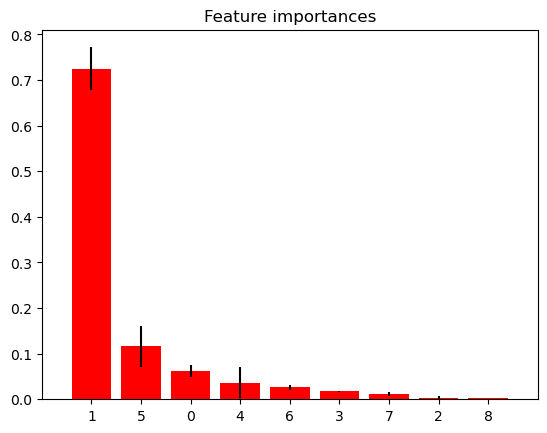

In [72]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [73]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

,Store,Dept,IsHoliday,Fuel_Price,Type,Size,week,month,year
0,1,1,False,2.572,1,151315,5,2,2010
330761,35,3,False,2.784,2,103681,5,2,2010
330762,35,4,False,2.784,2,103681,5,2,2010
330763,35,5,False,2.784,2,103681,5,2,2010
330764,35,6,False,2.784,2,103681,5,2,2010


In [77]:
#Model without month
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [78]:
wmae_test(y_test, y_pred_test)

5131.178189938809

# Model with whole data

In [79]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [80]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [81]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [82]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [83]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [84]:
wmae_test(y_test_enc, y_pred_test_enc)

2304.4558575839096

# Feature Importance for Whole Encoded Dataset

Feature ranking:
1. feature 1 (0.736689)
2. feature 8 (0.083104)
3. feature 7 (0.047505)
4. feature 5 (0.031419)
5. feature 0 (0.031071)
6. feature 6 (0.018288)
7. feature 9 (0.016712)
8. feature 3 (0.012826)
9. feature 4 (0.011136)
10. feature 10 (0.007304)
11. feature 11 (0.002033)
12. feature 2 (0.001912)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

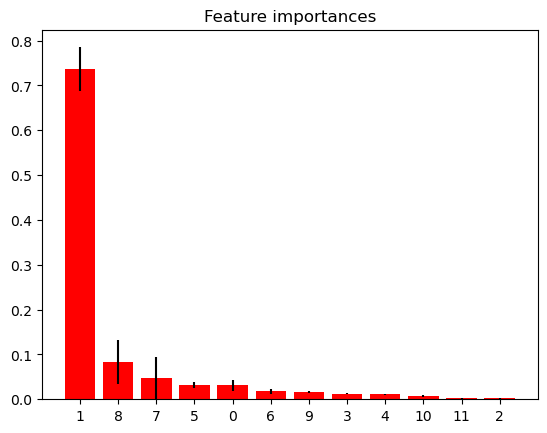

In [85]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

In [86]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

# Model According to Feature Importance

In [87]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [88]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [89]:
pipe.score(X_test_enc1,y_test_enc1)

0.7767126499483553

In [90]:
wmae_test(y_test_enc1, y_pred_test_enc)

1609.8210260172198

# Model with Dropping Month Column

In [91]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [92]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [93]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [94]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [95]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [96]:
pipe.score(X_test_enc2,y_test_enc2)

0.7691693590912365

In [97]:
wmae_test(y_test_enc2, y_pred_test_enc)

1602.469781358434